In [1]:
from ipynb.fs.full.dataset import load_conversations
from ipynb.fs.full.word2vec_implementation import build_word2vec
from ipynb.fs.full.dataset import preprocess_sentence

In [2]:
data_path_persona = "/home/parastoo/Desktop/t2t/Seq2seqChatbots/data_dir/DailyDialog/test_repo/trainSource.txt"
data_path_persona_target = "/home/parastoo/Desktop/t2t/Seq2seqChatbots/data_dir/DailyDialog/test_repo/trainSource.txt"
questions , answers = load_conversations(data_path_persona , data_path_persona_target)

In [3]:
data_path_rdany = "/home/parastoo/Downloads/human_text.txt"
data_path_rdany_target = "/home/parastoo/Downloads/robot_text.txt"
human , robot = load_conversations(data_path_rdany , data_path_rdany_target)

In [4]:
len_samples = len(questions)
questions1 = questions[:int(len_samples/5)]
answers1 = answers[:int(len_samples/5)]

questions2 = questions[int(len_samples/5) : 2*int(len_samples/5)]
answers2 = answers[int(len_samples/5) : 2*int(len_samples/5)]

questions3 = questions[2*int(len_samples/5) : 3*int(len_samples/5)]
answers3 = answers[2*int(len_samples/5) : 3*int(len_samples/5)]


In [5]:
import pandas as pd
import numpy as np
data = {'questions': questions , 'answers':answers}
pd.DataFrame(data).shape

(111135, 2)

In [6]:
word2vec = {}
vocab , inv_vocab , word2vec  = build_word2vec(questions1 , answers1 ,word2vec)
print(len(word2vec))
vocab , inv_vocab , word2vec = build_word2vec(questions2 , answers2 , word2vec)
print(len(word2vec))
vocab , inv_vocab , word2vec  = build_word2vec(questions3 , answers3 ,word2vec)
print(len(word2vec))
vocab , inv_vocab , word2vec  = build_word2vec(human , robot ,word2vec)
print(len(word2vec))

8720
11673
13820
16191


In [7]:
questions , answers = questions3, answers3

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def build_padded_encoder_input_data(questions , answers , vocab , inv_vocab):
    encoder_inp = []
    for line in questions:
        lst = []
        for word in line.split():
            if word not in vocab:
                lst.append(vocab['<OUT>'])
            else:
                lst.append(vocab[word])
        encoder_inp.append(lst)
    encoder_inp = pad_sequences(encoder_inp, 40, padding='post', truncating='post')
    return encoder_inp

def build_padded_decoder_input_data(questions, answers , vocab , inv_vocab):    
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    decoder_inp = []
    for line in answers:
        lst = []
        for word in line.split():
            if word not in vocab:
                lst.append(vocab['<OUT>'])
            else:
                lst.append(vocab[word])        
        decoder_inp.append(lst)
    decoder_inp = pad_sequences(decoder_inp, 40, padding='post', truncating='post')
    return decoder_inp
from tensorflow.keras.utils import to_categorical
def build_padded_decoder_final_output(decoder_inp, vocab , inv_vocab):
    decoder_final_output = []
    for i in decoder_inp:
        decoder_final_output.append(i[1:]) 
    decoder_final_output = pad_sequences(decoder_final_output, 40, padding='post', truncating='post')
    decoder_final_output = to_categorical(decoder_final_output, len(vocab))
    return(decoder_final_output)

In [9]:
encoder_inp  =  build_padded_encoder_input_data(questions , answers , vocab , inv_vocab)
decoder_inp = build_padded_decoder_input_data(questions , answers , vocab , inv_vocab)
decoder_final_output = build_padded_decoder_final_output(decoder_inp , vocab , inv_vocab)

In [10]:
from ipynb.fs.full.attention import AttentionLayer

In [11]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, Concatenate, Dropout, Attention
from numpy import array
import pandas as pd

In [12]:
embeddings_index = {}
with open('/home/parastoo/Downloads/glove.6B(1)/glove.6B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print("Glove Loded!")

Glove Loded!


In [13]:
embedding_dimention = 200
def embedding_matrix_creater(embedding_dimention, word_index):
    embedding_matrix = np.zeros((len(word_index)+1, embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
embedding_matrix = embedding_matrix_creater(embedding_dimention, word_index=vocab)    
print(embedding_matrix.shape)

(6975, 200)


In [14]:
VOCAB_SIZE = len(vocab)
MAX_LEN = 100

embed = Embedding(VOCAB_SIZE+1, 
                  embedding_dimention, 
                  
                  input_length=50,
                  trainable=True)

embed.build((None,))
embed.set_weights([embedding_matrix])


**_Model_**

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


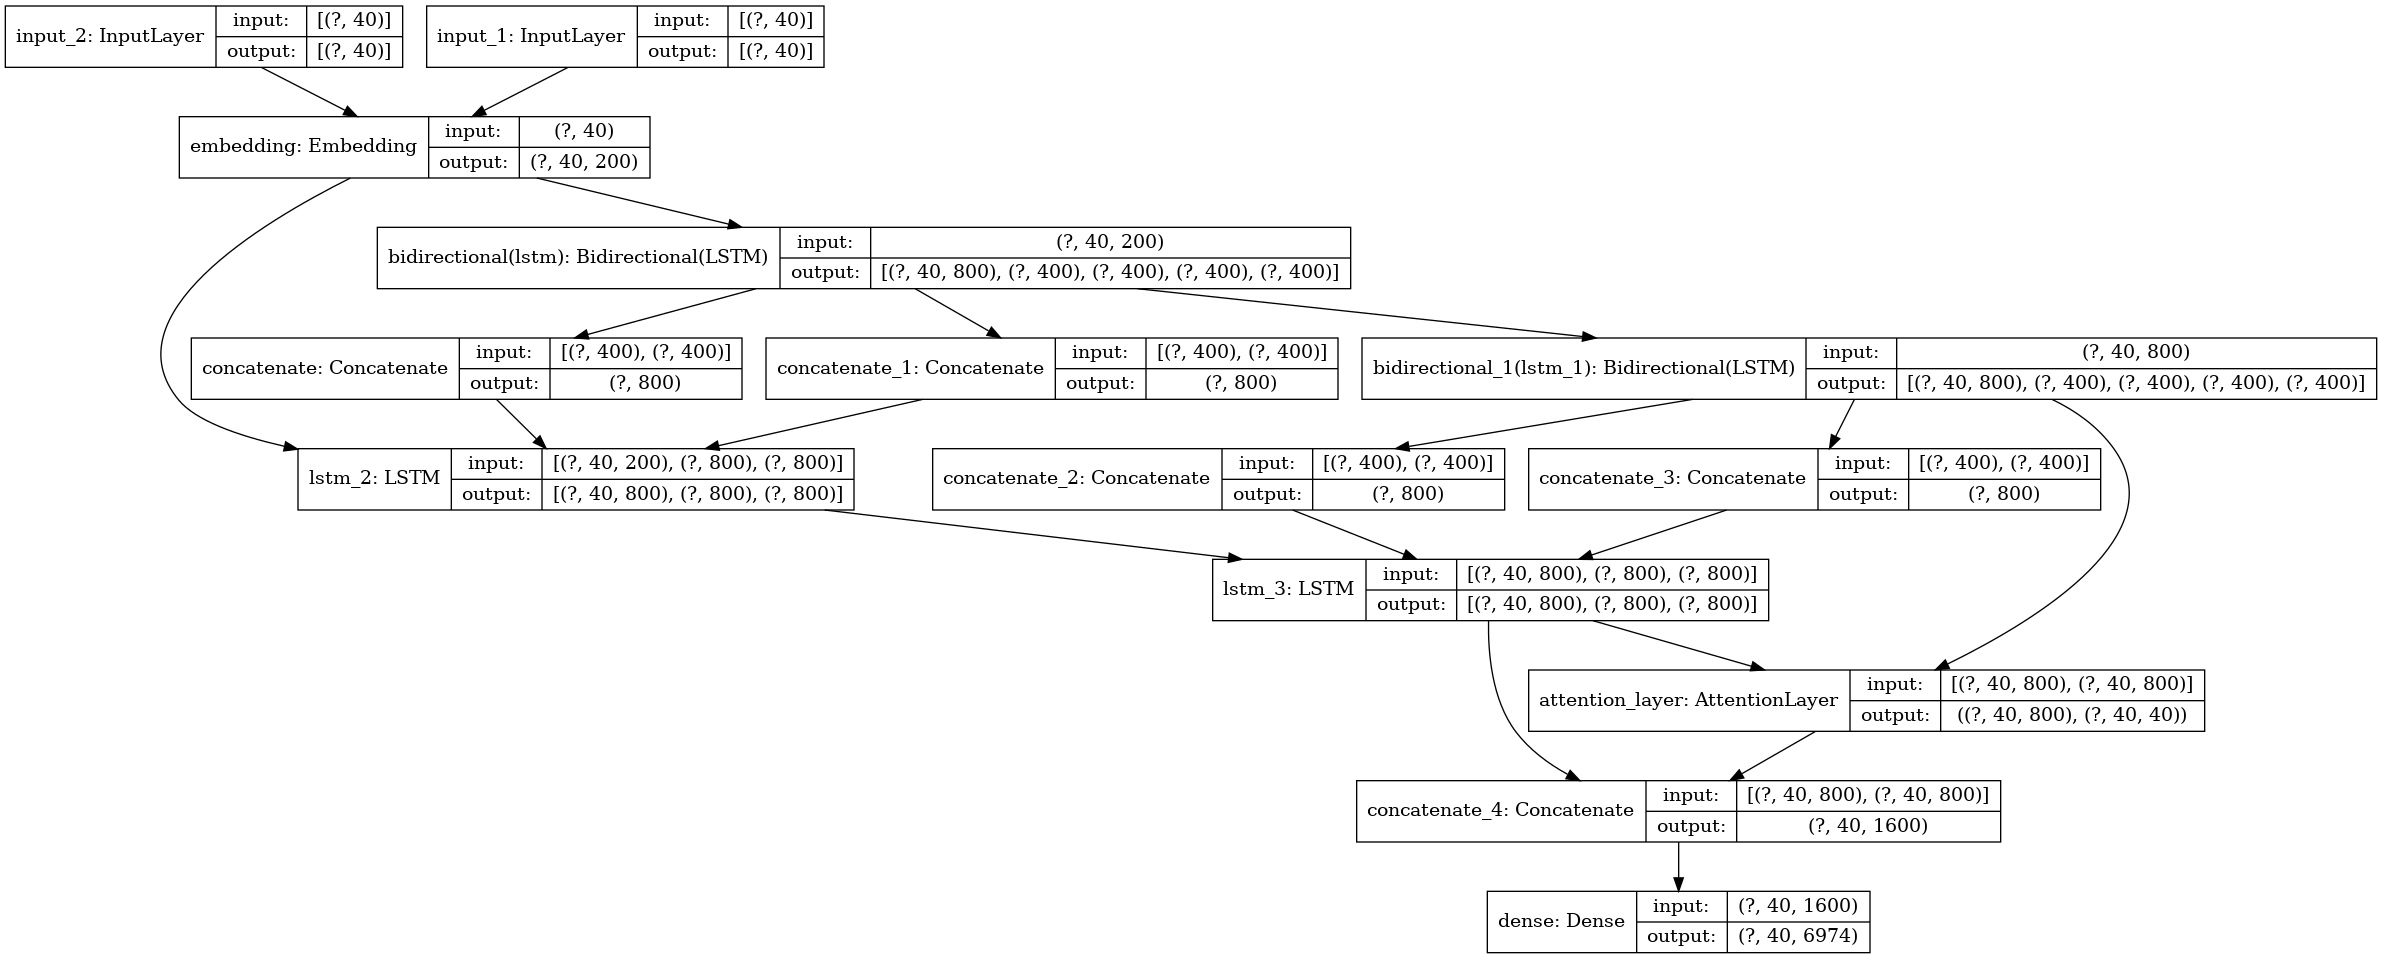

In [15]:
enc_inp = Input(shape=(40, ))
#embed = Embedding(VOCAB_SIZE+1, 50, mask_zero=True, input_length=13)(enc_inp)
enc_embed = embed(enc_inp)
enc_lstm = Bidirectional(LSTM(400, return_state=True, dropout=0.05, return_sequences = True))
enc_lstm_2 = Bidirectional(LSTM(400, return_state=True, dropout=0.05, return_sequences = True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = enc_lstm(enc_embed)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
enc_states_1 = [state_h, state_c]

encoder_outputs, forward_h, forward_c, backward_h, backward_c = enc_lstm_2(encoder_outputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
enc_states_2 = [state_h, state_c]

dec_inp = Input(shape=(40, ))
dec_embed = embed(dec_inp)
dec_lstm = LSTM(400*2, return_state=True, return_sequences=True, dropout=0.05)
output, _, _ = dec_lstm(dec_embed, initial_state=enc_states_1)
dec_lstm_2 = LSTM(400*2, return_state=True, return_sequences=True, dropout=0.05)
output, _, _ = dec_lstm_2(output, initial_state=enc_states_2)

# attention
attn_layer = AttentionLayer()
attn_op, attn_state = attn_layer([encoder_outputs, output])
decoder_concat_input = Concatenate(axis=-1)([output, attn_op])


dec_dense = Dense(VOCAB_SIZE, activation='softmax')
final_output = dec_dense(decoder_concat_input)

model = Model([enc_inp, dec_inp], final_output)
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

#model.summary()

In [16]:
len(encoder_inp)

22227

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit([encoder_inp, decoder_inp], decoder_final_output, epochs= 10
          , batch_size=64, validation_split=0.15)

Epoch 1/10
296/296 [==============================] - ETA: 0s - loss: 1.6361 - acc: 0.7378

In [ ]:
history = model.fit([encoder_inp, decoder_inp], decoder_final_output, epochs= 10
          , batch_size=64, validation_split=0.15)

In [ ]:
# list all data in history
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
enc_model = tf.keras.models.Model(enc_inp, [encoder_outputs, [enc_states_1 , enc_states_2]])


decoder_state_input_h_1 = tf.keras.layers.Input(shape=( 400 * 2,))
decoder_state_input_c_1 = tf.keras.layers.Input(shape=( 400 * 2,))
decoder_state_input_h_2 = tf.keras.layers.Input(shape=( 400 * 2,))
decoder_state_input_c_2 = tf.keras.layers.Input(shape=( 400 * 2,))

decoder_states_inputs = [decoder_state_input_h_1, decoder_state_input_c_1,
                         decoder_state_input_h_2, decoder_state_input_c_2]

decoder_outputs, state_h_1, state_c_1 = dec_lstm(dec_embed , 
                                               initial_state=decoder_states_inputs[:2])
decoder_outputs, state_h_2, state_c_2 = dec_lstm_2(decoder_outputs , 
                                               initial_state=decoder_states_inputs[-2:])

decoder_states = [state_h_1, state_c_1,state_h_2, state_c_2]
#decoder_output = dec_dense(decoder_outputs)
dec_model = tf.keras.models.Model([dec_inp, decoder_states_inputs],
                                      [decoder_outputs] + decoder_states)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
print("##########################################")
print("#       start chatting ver. 1.0          #")
print("##########################################")


prepro1 = ""
while prepro1 != 'q':
    
    prepro1 = input("you : ")
   
    prepro1 = preprocess_sentence(prepro1)
    prepro = [prepro1]
        
    txt = []
    for x in prepro:
        lst = []
        for y in x.split():
            try:
                 lst.append(vocab[y])
            except:
                lst.append(vocab['<OUT>'])
        txt.append(lst)
    txt = pad_sequences(txt, 20, padding='post')


        ###
    enc_op, stat = enc_model.predict( txt )

    empty_target_seq = np.zeros( ( 1 , 1) )
    empty_target_seq[0, 0] = vocab['<SOS>']
    stop_condition = False
    decoded_translation = ''

#     dead_k = 0 # samples that reached eos
#     dead_samples = []
#     dead_scores = []
#     live_k = 1 # samples that did not yet reached eos
#     live_samples = [[empty]]
#     live_scores = [0]

    while not stop_condition :
        dec_outputs , h1, c1 , h2 , c2 = dec_model.predict([ empty_target_seq ] + stat )
            ###
            ###########################
        attn_op, attn_state = attn_layer([enc_op, dec_outputs])
        decoder_concat_input = Concatenate(axis=-1)([dec_outputs, attn_op])
        decoder_concat_input = dec_dense(decoder_concat_input)
            ###########################
      #  print(type(dec_outputs))
        sampled_word_index = np.argmax( decoder_concat_input[0, -1, :] )

        sampled_word = inv_vocab[sampled_word_index] + ' '

        if sampled_word != '<EOS> ' and sampled_word != '<OUT> 'and sampled_word != '<PAD> ':
            decoded_translation += sampled_word           


        if sampled_word == '<EOS> ' or len(decoded_translation.split()) > 30:
            stop_condition = True

        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        stat = [ h1 , c1 , h2 ,c2 ] 
    print("chatbot attention : ", decoded_translation )
    print("==============================================")


In [ ]:
enc_model.save('enc_model_weights.h5')
loaded_enc_model = keras.models.load_model('enc_model_weights.h5')
enc_model.summary()

In [ ]:
from wtforms import (Form, TextField, validators, SubmitField, 
DecimalField, IntegerField)

class ReusableForm(Form):
    """User entry form for entering specifics for generation"""
    # Starting seed
    seed = TextField("Enter a seed string or 'random':", validators=[
                     validators.InputRequired()])
    # Diversity of predictions
    diversity = DecimalField('Enter diversity:', default=0.8,
                             validators=[validators.InputRequired(),
                                         validators.NumberRange(min=0.5, max=5.0,
                                         message='Diversity must be between 0.5 and 5.')])
    # Number of words
    words = IntegerField('Enter number of words to generate:',
                         default=50, validators=[validators.InputRequired(),
                                                 validators.NumberRange(min=10, max=100, 
                                                 message='Number of words must be between 10 and 100')])
    # Submit button
    submit = SubmitField("Enter")

In [48]:
from flask import render_template

# Home page
@app.route("/", methods=['GET', 'POST'])
def home():
    """Home page of app with form"""
    # Create form
    form = ReusableForm(request.form)

    # Send template information to index.html
    return render_template('index.html', form=form)

NameError: name 'app' is not defined